In [26]:
# -*- coding: utf-8 -*-

In [27]:
%matplotlib inline
from IPython.display import display

In [28]:
# import io
# from nbformat import current

# def execute_notebook(nbfile):
    
#     with io.open(nbfile) as f:
#         nb = current.read(f, 'json')
    
#     ip = get_ipython()
    
#     for cell in nb.worksheets[0].cells:
#         if cell.cell_type != 'code':
#             continue
#         ip.run_cell(cell.input)

In [29]:
# execute_notebook("speechutils.ipynb")

In [30]:
%run "speechutils.py"

In [31]:
ch = callhome_eval_init("config.json")

../../ZRTools/exp/callhome_train_50_evad/matches/config0.80-0.97-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 2173 and List length: 2817
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Total matches: 2173
matches with missing transcriptions: 0
matches with only sil, sp: 78
Finished - evaluating 2173 pairs ...
Setting up eval data frame
Finished ...
Saving state dictionary ...
Finished saving state dictionary ...
Total wav files: 9165
+--------------------------------------+-------------

In [33]:
df_zrt, cols_to_show = ch.gen_zrt_df()

# Analyse ZRT output

### Set up visualizations

In [34]:
pd.options.display.float_format = '{:,.3f}'.format

In [35]:
df_zrt[cols_to_show].head(3)

,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.930,EN DONDE,EN DONDE,1,1.000,0,0.000,0.930,1.049.040,1.049.040
1,3,4,0.864,DONDE,ASUNTO sp DE,0,0.250,0,0.000,0.778,1.049.040,2.063.164
2,4,1448,0.835,ASUNTO sp DE,ESTE,0,0.250,0,0.000,0.751,2.063.164,2.106.025


## Pairs discovered

### Filter Pairs

In [36]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)

+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |    2173    |
+-----------------------------------------+------------+
|             With sil, sp, or no matches |     78     |
+-----------------------------------------+------------+
| Pairs with speech segments and ES words |    2095    |
+-----------------------------------------+------------+


## Histogram - ZRT values

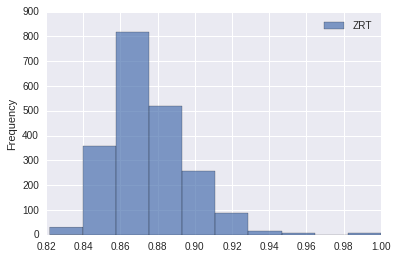

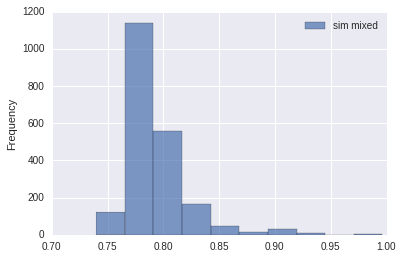

In [37]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)

# Long matches

In [38]:
df_long_dur = df_valid[df_valid['dur'] > 600]
print(len(df_long_dur))
df_long_dur[cols_to_show].head()

102


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.930,EN DONDE,EN DONDE,1,1.000,0,0.000,0.930,1.049.040,1.049.040
187,181,182,0.905,Y,VIENDO,0,0.000,0,0.040,0.818,2.050.045,1.106.076
190,187,188,0.904,Y,VIENDO,0,0.000,0,0.040,0.818,2.050.045,1.106.076
193,207,208,0.897,CONSTITUCIóN,QUE HABRá,0,0.000,0,0.000,0.897,2.050.048,2.050.048
194,209,210,0.912,CONSTITUCIóN,QUE HABRá,0,0.000,0,0.000,0.912,2.050.048,2.050.048


In [40]:
ch.play_pair_wav(193)

Playing evaluation pair id: 193
Pair text details
+---------+---------------+----------------------------------------------------+
| node id | ES transcript |                   EN translation                   |
+---------+---------------+----------------------------------------------------+
|   207   |  CONSTITUCIóN |   the pld has proposed to call for the house of    |
|         |               | representatives to approve a new constitution that |
|         |               |    says that the reelection of the president is    |
|         |               |   prohibited in consecutive terms and that there   |
|         |               |             will be separate elections             |
+---------+---------------+----------------------------------------------------+
|   208   |   QUE HABRá   |   the pld has proposed to call for the house of    |
|         |               | representatives to approve a new constitution that |
|         |               |    says that the reelection of 

## Phoneme Similarity

For high DTW score pairs, the phone similarity score should be high as well.

Conversely, if phone similarity is very low, the pair may not be a good match.

### High phoneme score

Pairs with high phoneme similarity score: 564


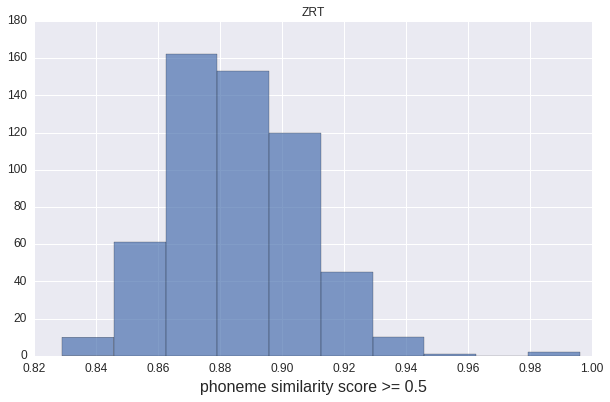

In [38]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [39]:
df_phone_score_hi[cols_to_show].head(3)

,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.930,EN DONDE,EN DONDE,1,1.000,0,0.000,0.930,1.049.040,1.049.040
6,7,8,0.883,NOSOTROS NOS VAMOS,NOSOTROS VAMOS,1,0.583,1,0.000,0.795,2.049.068,2.049.088
7,9,10,0.886,NOSOTROS VAMOS,NOSOTROS NOS VAMOS,1,0.636,1,0.000,0.797,2.049.088,2.049.068


In [ ]:
ch.play_pair_wav(6)

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(22, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

In [ ]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[df_phone_score_hi['EN sim'] == 0]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(10)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [ ]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) & (df_valid['EN sim'] == 0)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(10)

In [ ]:
display(ch.play_pair_wav(0, detail=True))

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
ch.play_pair_wav(25838, detail=True)

## Precision / Recall

In [ ]:
ch.eval_precision_recall()

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

# eval scores: 2095
# good scores: 314
#  bad scores: 1781
Average Precision - using sim: zrt_sim
----------------------------------------
	0.41228
----------------------------------------
# eval scores: 2095
# good scores: 314
#  bad scores: 1781
Average Precision - using sim: sim mixed
----------------------------------------
	0.59682
----------------------------------------


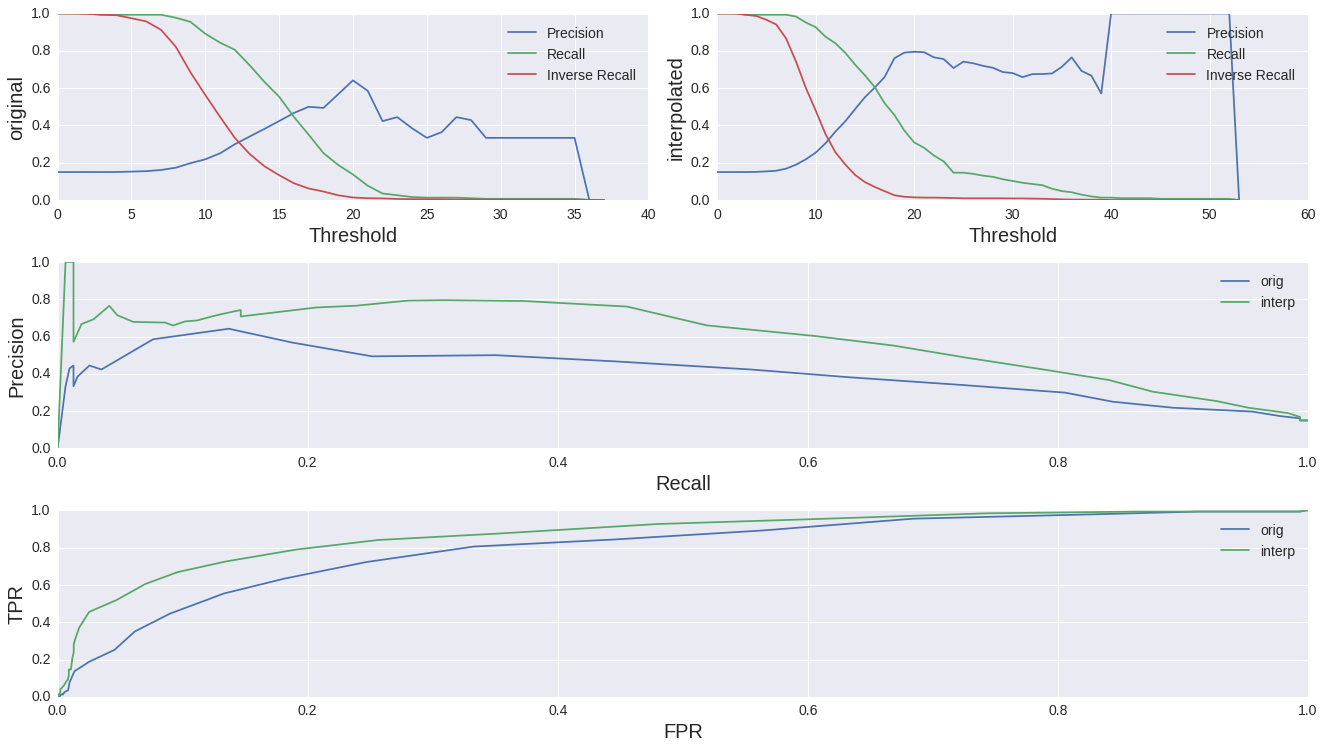

In [40]:
ch.plot_precision_recall(both=True)

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES phone edit sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])